this notebook has 2 phases:

* in the first part we define a function that draws the fourrier curven given coefficients

* second part is a neural net aiming at doing the reciprocate

 inspired by https://www.youtube.com/watch?v=-qgreAUpPwM

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
import numpy as np
from operator import itemgetter
import pandas as pd
import cmath
# parameters
FOURRIER_DIM = 10
RESOLUTION_ANGULAR = 1/90.

In [2]:
%matplotlib notebook

# Drawing from coefficients


In [3]:
class FourrierCurve(dict):
    def __init__(self, keys, values):
        """
        keys: list of integers frequencies (relative)
        values: list of complex coefficient for each integer frequency
        """
        self.update(zip(keys, values))
        self.trajectory = None

    def __getitem__(self, key):
        """
        default complex coefficient
        """
        return self.get(key, complex(0,0))

    def compute_trajectory(self):
        freqs = list(filter(
            lambda x: x!=0,
            sorted(self.keys(), key=lambda k : np.abs(k) + (0.5*k>0))
        ))

        steps = np.arange(0, 1, RESOLUTION_ANGULAR)

        unitary_rotation = pd.Series(
            data = [cmath.rect(1, 2*np.pi*freq*RESOLUTION_ANGULAR) for freq in freqs],
            index=freqs
        )

        coefs = pd.Series(
            data = [self[freq] for freq in freqs],
            index=freqs
        )

        res = pd.concat([unitary_rotation]*len(steps), axis=1)
        res.columns = steps

        # for a given angle n, the rotation is the sum of n unitary roations
        res = res.cumprod(axis=1)

        # multiply by initial coefficient
        res = res.multiply(coefs, axis=0)
        # total position of the nth arrow
        res = res.cumsum(axis=0)
        # add start
        res = res.add(self[0])
        self.trajectory = res
        return

    def draw(self):
        if self.trajectory is None:
            self.compute_trajectory()
        # draw end
        # last row = position of the end of the arrows
        # separate into imaginary and real part
        coordinates = self.trajectory.iloc[-1, :].apply(complex_to_xy).apply(pd.Series)
        plt.plot(coordinates[0], coordinates[1])
        plt.axis('equal')
        plt.show()

        return

    def animate(self):
        if self.trajectory is None:
            self.compute_trajectory()
        
        # animate
        # animation: https://matplotlib.org/3.2.1/api/animation_api.html
        # animation patch: https://stackoverflow.com/questions/19981054/animating-patch-objects-in-python-matplotlib
        # https://stackoverflow.com/questions/22771111/using-matplotlib-patch-inside-an-animation
        # anim within function: https://stackoverflow.com/questions/21099121/python-matplotlib-unable-to-call-funcanimation-from-inside-a-function/21116525#21116525

        fig, ax = plt.subplots()
        xend, yend = [], []
        xarrows, yarrows = [], []
        ln, = plt.plot([], [], '.')
        arr, = plt.plot([], [])
        cir = []

        store_arr = dict(
            [
                (
                    frame, zip([0,0], complex_to_xy(self[0]), *self.trajectory[frame].apply(complex_to_xy).to_list())
                ) for frame in self.trajectory.columns
            ]
        )


        def _init():
            ax.set_xlim(-5, 5)
            ax.set_ylim(-5, 5)
            for f in [0] + list(self.trajectory.index):
                cir.append(ax.add_patch(mpl.patches.Circle((0,0), radius=abs(self[f]), fill=False, alpha=0.2)))
            return [ln, arr]+ cir

        def _update(frame):
            x, y = store_arr[frame]
            xend.append(x[-1])
            yend.append(y[-1])
            ln.set_data(xend, yend)
            arr.set_data(x, y)
            for idx, c in enumerate(cir):
                c.set_center((x[idx], y[idx]))
            return [ln, arr]+ cir

        ani = FuncAnimation(fig, _update, frames=self.trajectory.columns,
                            init_func=_init, blit=True)
        plt.axis('equal')
        plt.show()
        return ani
        
def complex_to_xy(x): return (x.imag, x.real)


In [7]:
test = FourrierCurve([0, 1, -1, 3], [complex(0,0), complex(1,0), complex(0.5,0.5), complex(1,0)])
test2 = FourrierCurve([0, 1, -1, 3, -3], [complex(1,0), complex(1,0), complex(0.5,0.5), complex(1,0), complex(0.2, 0.2)])

<IPython.core.display.Javascript object>


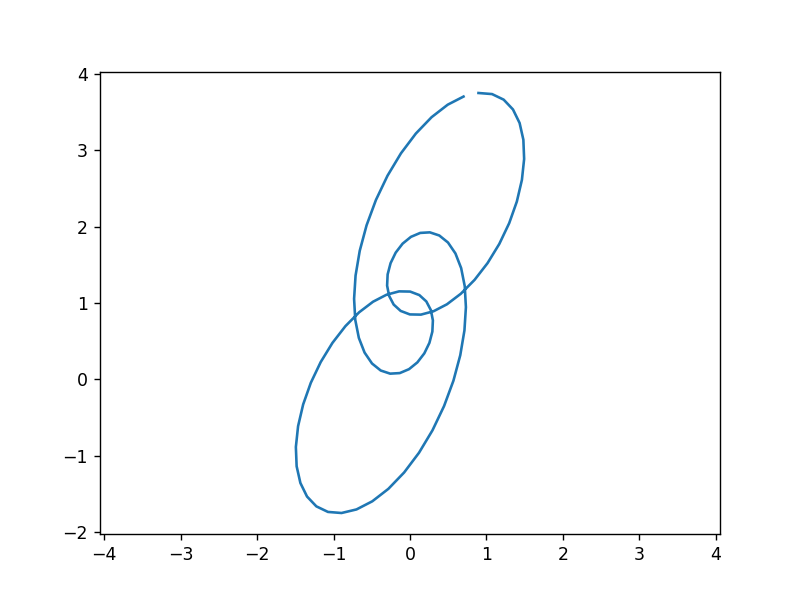

In [8]:
test2.draw()

<IPython.core.display.Javascript object>


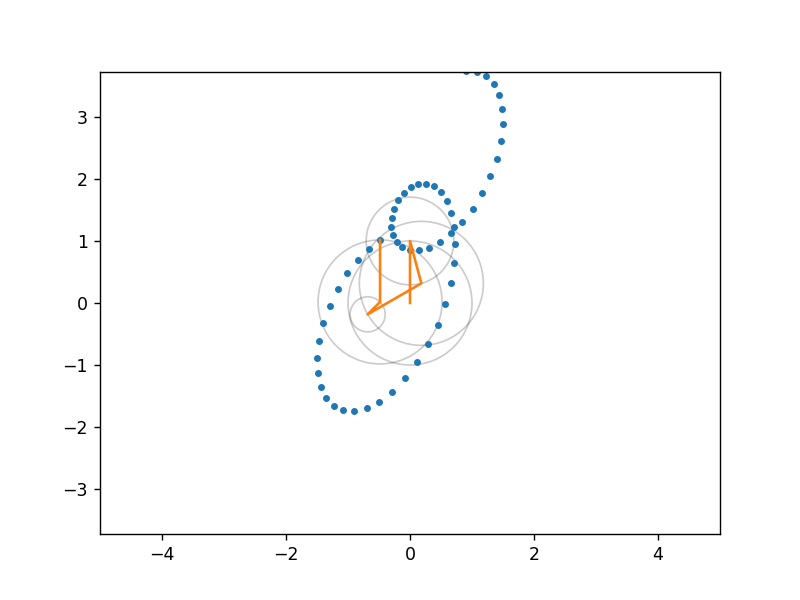

In [9]:
a = test2.animate()